In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression

%matplotlib inline

In [2]:
train = pd.read_csv("C:\\Users\\sidar\\Downloads\\Titanic\\train.csv")
test = pd.read_csv("C:\\Users\\sidar\\Downloads\\Titanic\\test.csv")

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
for col in train.columns.tolist():          
        print('{} column missing values: {}'.format(col, train[col].isnull().sum()))

PassengerId column missing values: 0
Survived column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 177
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 0
Cabin column missing values: 687
Embarked column missing values: 2


In [5]:
# Testing Feature: Sex

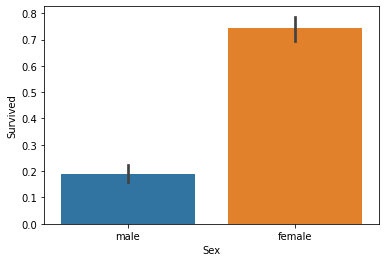

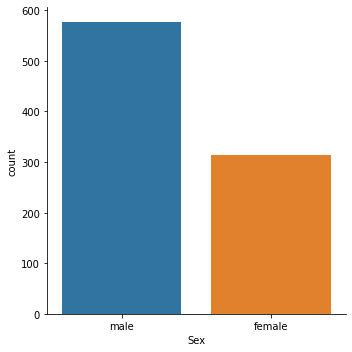

In [9]:
sns.barplot(x=train['Sex'], y=train['Survived'])
sns.catplot(x="Sex", kind="count", data=train)

In [8]:
# Sex seeems to be a major feature in the likelihood of a passenger's survival, owing to the fact that the survival
# rate of females is much higher than that of males.

In [9]:
percentages = (train['Sex'].isnull().sum() / train['Sex'].isnull().count())
percentages

0.0

In [10]:
# Testing Feature: Pclass

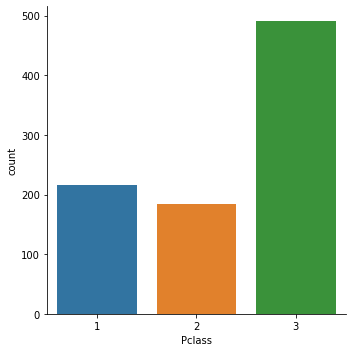

In [11]:
sns.catplot(x="Pclass", kind="count", data=train)

<AxesSubplot:xlabel='Pclass', ylabel='count'>

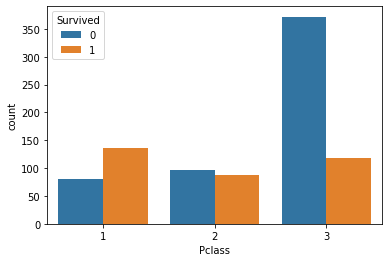

In [12]:
sns.countplot(x="Pclass", hue="Survived", data=train)

In [13]:
# From this graph, it becomes quite evident that the passengers in class 1 were given a lot of priority in the rescue
# efforts, despite the fact that there were way more people in class 3. Therefore, this seems to be an important
# feature that could be used to orient the model.

In [14]:
percentages = (train['Pclass'].isnull().sum() / train['Pclass'].isnull().count())
percentages

0.0

In [15]:
# Testing Feature: Age

<AxesSubplot:xlabel='Age', ylabel='count'>

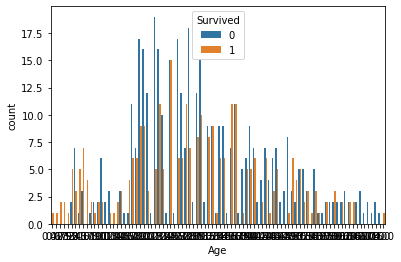

In [16]:
sns.countplot(x="Age", hue="Survived", data=train)

In [17]:
# Now, we know that age has 177 missing values, but it does seem like a critical factor to include in our survivability
# calculation. Hence, we're going to use a feature that has a high correlation both with Age and survivability, i.e.
# Pclass, to fill in the missing values for the Age column using the median value of the age group in each class.
# This is done in order to make the filled-in values a little more sensible than a general median of the entire ship's 
# age range.

print(train['Age'].corr(train['Pclass']), 
      train['Survived'].corr(train['Pclass']))

-0.3692260153155173 -0.3384810359610148


In [18]:
train['Age'] = train.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

In [19]:
percentages = (train['Age'].isnull().sum() / train['Age'].isnull().count())
percentages

0.0

In [20]:
# One-hot-encoding Sex (females are 1)

dummy = pd.get_dummies(train['Sex'])

In [21]:
train = pd.concat([train, dummy], axis=1).drop(['Sex', 'male'], axis=1)

train.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,female
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,0


In [22]:
# MODEL

cols = ['Pclass', 'Age', 'Parch', 'SibSp', 'female']

In [23]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss

# create X (features) and y (response)
X_train = train[cols]
y_train = train['Survived']

# use train/test split with different random_state values
# we can change the random_state values that changes the accuracy scores
# the scores change a lot, this is why testing scores is a high-variance estimate
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# check classification scores of logistic regression
#model = LogisticRegression()
#model.fit(X_train, y_train)
#y_pred = model.predict(X_test)
#y_pred_proba = model.predict_proba(X_test)[:, 1]

##########################################################
def sigmoid(z):
    return 1/(1+np.exp(-z))

def f(X, theta):
    return sigmoid(X.dot(theta))

def log_likelihood(theta, X, y):
    return(y*np.log(f(X, theta)+1e-6)+(1-y)*np.log(1-f(X, theta)+1e-6)).mean()

def loglik_gradient(theta, X, y):
    return np.mean((y - f(X, theta)) * X.T, axis=1)

threshold=5e-5
step_size=1e-2
itern=0

theta, theta_prev=np.zeros((5,)), np.ones((5,))
opt_pts=[theta]
opt_grads=[]
while np.linalg.norm(theta - theta_prev) > threshold:
    if itern%5000 == 0:
        print('Iteration %d. Log-likelihood:%.6f' % (itern, log_likelihood(theta, X_train, y_train)))
    theta_prev=theta
    gradient=loglik_gradient(theta, X_train, y_train)
    theta=theta_prev+step_size*gradient
    opt_pts+=[theta]
    opt_grads+=[gradient]
    itern += 1
##########################################################

#print('Train/Test split results:')
#print(logreg.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, y_pred))
#print(logreg.__class__.__name__+" log_loss is %2.3f" % log_loss(y_test, y_pred_proba))
#print(logreg.__class__.__name__+" auc is %2.3f" % auc(fpr, tpr))

#idx = np.min(np.where(tpr > 0.95)) # index of the first threshold for which the sensibility > 0.95

Iteration 0. Log-likelihood:-0.693145
Iteration 5000. Log-likelihood:-0.466506


In [24]:
test['Age'] = test.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))
dummy = pd.get_dummies(test['Sex'])
test = pd.concat([test, dummy], axis=1).drop(['Sex', 'male'], axis=1)

In [34]:
Id = test['PassengerId']
test_X = test[cols]

pred_survivability = sigmoid(np.dot(test_X, theta))
final_survivability = np.array([1 if i>0.5 else 0 for i in pred_survivability])

In [38]:
submission = pd.concat([Id, pd.DataFrame(final_survivability)], axis=1)
submission.columns = ['PassengerId', 'Survived']

In [39]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [40]:
submission.to_csv('titanic_sub.csv', index=False)